In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab
import os

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
def Image_Processing(file_name):
    img = cv2.imread("HEImgs/"+ file_name)
    file_name = file_name[:-4]
    i = img
    image = img

    #----------------------------------INFLAMMATION DETECTION--------------------------------------------
    plt.subplot(121), plt.imshow(img), plt.title(file_name), plt.xticks([]), plt.yticks([])
    #convert to hsv from bgr
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    rg = cv2.merge([r,g,b])
    rg = rg.astype(np.float32)

    np.seterr(all = 'ignore')
    mask = np.empty_like(rg)
    arr_max = rg.max(-1)
    delta = rg.ptp(-1)
    s = delta/arr_max
    s[delta==0]=0
    idx = (rg[:,:,0] == arr_max)
    mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
    idx = (rg[:,:,1] == arr_max)
    mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
    idx = (rg[:,:,2] == arr_max)
    mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
    mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
    mask[:,:,0] = np.nan_to_num(mask[:,:,0])
    mask[:,:,1] = s * 255.0
    mask[:,:,2] = arr_max
    mask = mask.astype(np.uint8)

    #threshold to segment nuclei then invert
    hsv_thresh = cv2.inRange(mask, (120,0,0), (190,255,235))
    plt.subplot(122), plt.imshow(hsv_thresh, cmap = 'gray'), plt.title("HSV Thresh"), plt.xticks([]), plt.yticks([])

    _, nuclei_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    nuclei_img = np.zeros(hsv_thresh.shape, np.uint8)
    centroid = []

    #find centroids and place centroids in a list
    for c in nuclei_cnt:
        if cv2.contourArea(c) > 50:
            moment = cv2.moments(c)
            if moment['m00'] != 0.0:
                cx = moment['m10']/moment['m00']
                cy = moment['m01']/moment['m00']
                centroid.append((cx,cy))
                #print("{0:.2f}".format(cx), ", {0:.2f}".format(cy))
                cv2.drawContours(nuclei_img, [c], 0, 255, -1)

    print("Size of Centroids: ", len(centroid))
    # goes through centroids and finds distance between each centroid (timely process) and based on distance, adds the pair to list
    plt.subplot(122), plt.imshow(nuclei_img, cmap = 'gray'), plt.title("Drawn Contours"), plt.xticks([]), plt.yticks([]), plt.show()
    clusters = []
    for x in range(len(centroid)):
        for y in range(len(centroid)):
            distance = np.sqrt(np.square(centroid[y][0]-centroid[x][0])+np.square(centroid[y][1]-centroid[x][1]))
            if ((centroid[y],centroid[x]) not in clusters) and distance <= 50:
                #centroid looks like: (x,y)
                #clusters[0] looks like: (x,y),(x,y)
                #clusters[0][0] looks like: (x,y)
                clusters.append((centroid[x],centroid[y]))
    print("Size of Clusters: ", len(clusters))
    lists = {}
    a = 0

    #goes through list of clusters, adds pair to dict
    for x in range(len(clusters)):
        if len(lists) == 0:
            key = "list_" + str(a)
            lists[key] = []
            lists[key].append(clusters[x][0])
            lists[key].append(clusters[x][1])
            a += 1

        else:
            len_list = -1
            for y in list(lists):
                len_list += 1
                if clusters[x][0] in lists[y] and clusters[x][1] not in lists[y]:
                    lists[y].append(clusters[x][1])
                    break
                elif clusters[x][1] in lists[y] and clusters[x][0] not in lists[y]:
                    lists[y].append(clusters[x][0])
                    break
                elif clusters[x][0] in lists[y] and clusters[x][1] in lists[y]:
                    break

                elif len_list == len(lists)-1:
                    key = "list_" + str(a)
                    lists[key] = []
                    lists[key].append(clusters[x][0])
                    a += 1

    print("Current number of clusters: ", len(lists))
    print("Number of cells in clusters: ")
    for y in list(lists):
        print("\t", y,": ", len(lists[y]))
        if len(lists[y]) < 15:
            lists.pop(y)

    print("Current number of clusters: ", len(lists))
    rectangle_mask = np.zeros(hsv_thresh.shape, np.uint8)

    for y in list(lists):
            topmost = 1280
            bottommost = 0
            leftmost = 1280
            rightmost = 0
            for x in range(len(lists[y])):
                if (lists[y][x][0] < leftmost):
                    leftmost = int(lists[y][x][0])
                if (lists[y][x][1] < topmost):
                    topmost = int(lists[y][x][1])
                if (lists[y][x][0] > rightmost):
                    rightmost = int(lists[y][x][0])
                if (lists[y][x][1] > bottommost):
                    bottommost = int(lists[y][x][1])
            #cluster_results[a] = []
            #cluster_results[a].append(len(lists[y]))
            #size = (bottommost-topmost)*(rightmost-leftmost)
            #cluster_results[a].append(size)
            cv2.rectangle(rectangle_mask, (leftmost-5, bottommost-5), (rightmost+5, topmost+5), 255, 4)
            
    cluster_results = {}
    a = 0  
    _, rectangle_cnt, _ = cv2.findContours(rectangle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in rectangle_cnt:
        a +=1
        point_cnt = 0
        cluster_results[a] = []
        for i in range(len(centroid)):
            num = cv2.pointPolygonTest(c, centroid[i], False)
            if num == 0 or num == 1:
                point_cnt += 1
        cluster_results[a].append(point_cnt)
        cluster_results[a].append(cv2.contourArea(c))
        cv2.drawContours(img, [c], 0, (255,0,0), 4)

#--------------------------------VESSEL DETECTION------------------------------------------------------------
    thresh = cv2.inRange(mask, (0,40,0), (255,255,255))
    thresh = 255 - thresh
    _, vessel_cnt, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    new_vessel = np.zeros(thresh.shape, np.uint8)
    for c in vessel_cnt:
        if cv2.contourArea(c) > 2000:
            perimeter = cv2.arcLength(c, True)
            if (4*np.pi*cv2.contourArea(c))/(perimeter*perimeter) >= 0.1:
                cv2.drawContours(img, [c], 0, (0,255,0), 4)
            
    plt.imshow(img), plt.title(file_name), plt.xticks([]), plt.yticks([]), plt.show() 
    return (img,cluster_results, nuclei_img)

Size of Centroids:  130


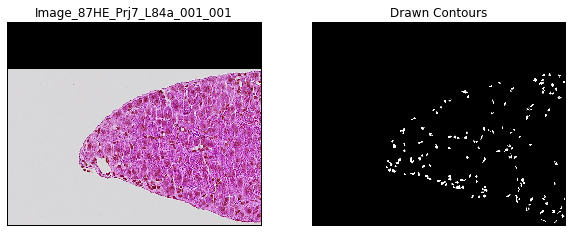

Size of Clusters:  276
Current number of clusters:  40
Number of cells in clusters: 
	 list_32 :  5
	 list_15 :  4
	 list_18 :  1
	 list_8 :  2
	 list_35 :  13
	 list_37 :  2
	 list_1 :  5
	 list_38 :  2
	 list_22 :  1
	 list_29 :  3
	 list_13 :  4
	 list_6 :  1
	 list_10 :  1
	 list_16 :  2
	 list_19 :  2
	 list_34 :  1
	 list_14 :  1
	 list_20 :  1
	 list_30 :  2
	 list_17 :  6
	 list_9 :  6
	 list_27 :  2
	 list_33 :  1
	 list_4 :  5
	 list_25 :  2
	 list_12 :  1
	 list_26 :  2
	 list_39 :  2
	 list_23 :  5
	 list_21 :  1
	 list_5 :  22
	 list_3 :  8
	 list_28 :  1
	 list_31 :  1
	 list_11 :  1
	 list_24 :  4
	 list_36 :  2
	 list_7 :  3
	 list_2 :  4
	 list_0 :  7
Current number of clusters:  1


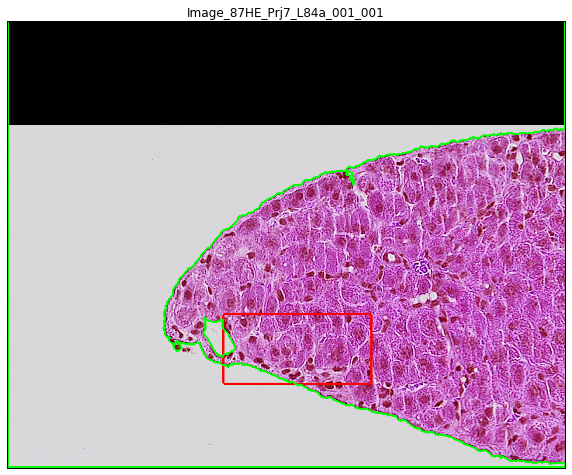

Size of Centroids:  197


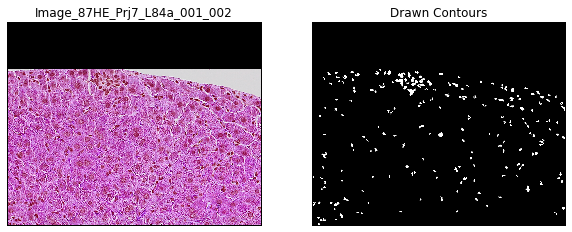

Size of Clusters:  397
Current number of clusters:  81
Number of cells in clusters: 
	 list_52 :  1
	 list_13 :  3
	 list_65 :  1
	 list_8 :  2
	 list_35 :  5
	 list_60 :  9
	 list_78 :  1
	 list_38 :  1
	 list_47 :  2
	 list_29 :  1
	 list_21 :  2
	 list_6 :  1
	 list_67 :  9
	 list_34 :  2
	 list_14 :  1
	 list_20 :  2
	 list_30 :  3
	 list_37 :  1
	 list_73 :  18
	 list_43 :  2
	 list_4 :  1
	 list_9 :  2
	 list_61 :  6
	 list_39 :  1
	 list_64 :  3
	 list_5 :  1
	 list_36 :  2
	 list_70 :  3
	 list_54 :  2
	 list_80 :  2
	 list_31 :  1
	 list_11 :  1
	 list_3 :  2
	 list_76 :  1
	 list_7 :  1
	 list_2 :  2
	 list_0 :  5
	 list_72 :  6
	 list_15 :  5
	 list_18 :  3
	 list_42 :  1
	 list_66 :  8
	 list_1 :  7
	 list_51 :  2
	 list_74 :  1
	 list_75 :  11
	 list_45 :  5
	 list_55 :  3
	 list_22 :  1
	 list_10 :  1
	 list_19 :  1
	 list_79 :  1
	 list_63 :  1
	 list_16 :  1
	 list_17 :  1
	 list_46 :  1
	 list_69 :  1
	 list_57 :  1
	 list_24 :  1
	 list_68 :  1
	 list_77 :  1
	 list_2

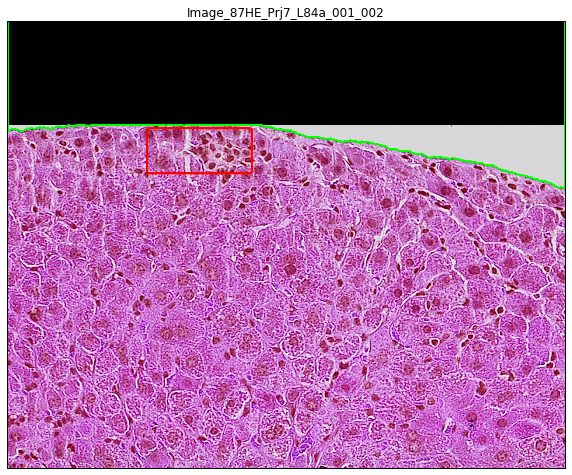

Size of Centroids:  128


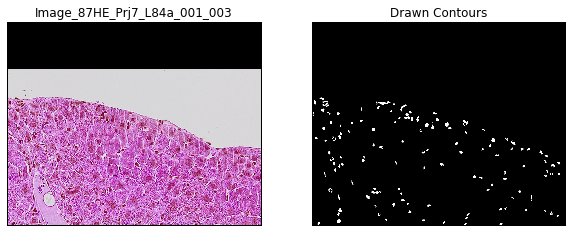

Size of Clusters:  228
Current number of clusters:  53
Number of cells in clusters: 
	 list_52 :  2
	 list_13 :  2
	 list_8 :  5
	 list_35 :  3
	 list_38 :  9
	 list_47 :  6
	 list_29 :  2
	 list_21 :  2
	 list_6 :  3
	 list_34 :  3
	 list_14 :  1
	 list_20 :  2
	 list_30 :  1
	 list_37 :  1
	 list_43 :  2
	 list_4 :  4
	 list_9 :  1
	 list_39 :  4
	 list_5 :  1
	 list_36 :  2
	 list_31 :  2
	 list_11 :  1
	 list_3 :  1
	 list_7 :  3
	 list_2 :  1
	 list_0 :  4
	 list_15 :  3
	 list_18 :  2
	 list_42 :  1
	 list_1 :  1
	 list_51 :  3
	 list_45 :  7
	 list_22 :  9
	 list_10 :  2
	 list_19 :  1
	 list_16 :  1
	 list_17 :  2
	 list_46 :  2
	 list_24 :  8
	 list_25 :  1
	 list_12 :  1
	 list_33 :  2
	 list_23 :  1
	 list_49 :  2
	 list_50 :  1
	 list_48 :  1
	 list_27 :  1
	 list_40 :  5
	 list_32 :  2
	 list_28 :  1
	 list_44 :  3
	 list_41 :  1
	 list_26 :  1
Current number of clusters:  0


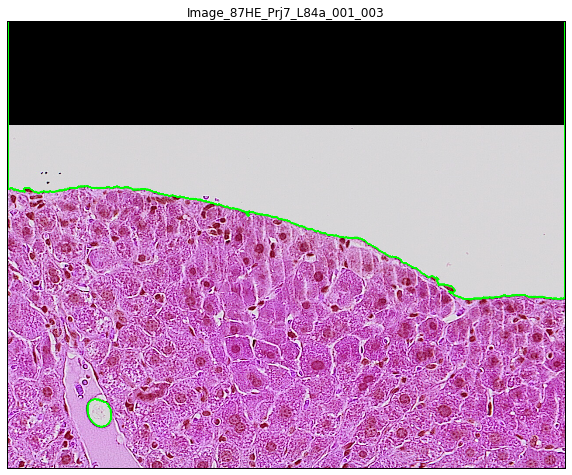

Size of Centroids:  46


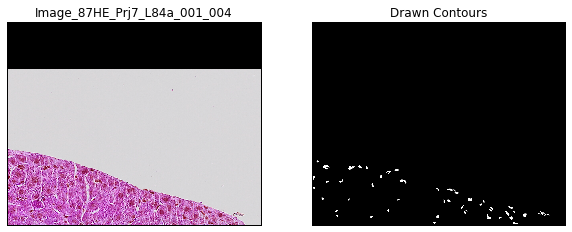

Size of Clusters:  69
Current number of clusters:  29
Number of cells in clusters: 
	 list_15 :  1
	 list_18 :  1
	 list_8 :  2
	 list_1 :  2
	 list_22 :  1
	 list_13 :  1
	 list_6 :  1
	 list_10 :  2
	 list_16 :  2
	 list_19 :  1
	 list_14 :  1
	 list_20 :  1
	 list_17 :  1
	 list_9 :  1
	 list_27 :  1
	 list_4 :  2
	 list_25 :  3
	 list_12 :  2
	 list_26 :  1
	 list_23 :  3
	 list_21 :  1
	 list_5 :  3
	 list_3 :  1
	 list_28 :  1
	 list_11 :  2
	 list_24 :  1
	 list_7 :  1
	 list_2 :  5
	 list_0 :  5
Current number of clusters:  0


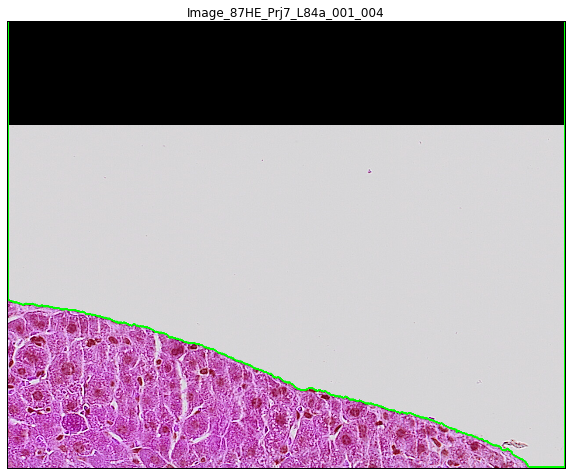

Size of Centroids:  0


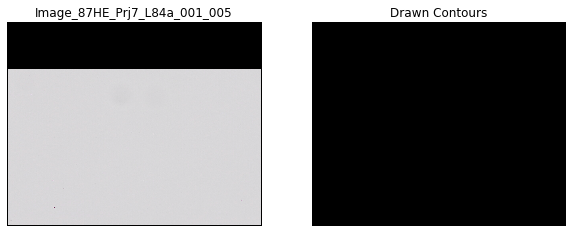

Size of Clusters:  0
Current number of clusters:  0
Number of cells in clusters: 
Current number of clusters:  0


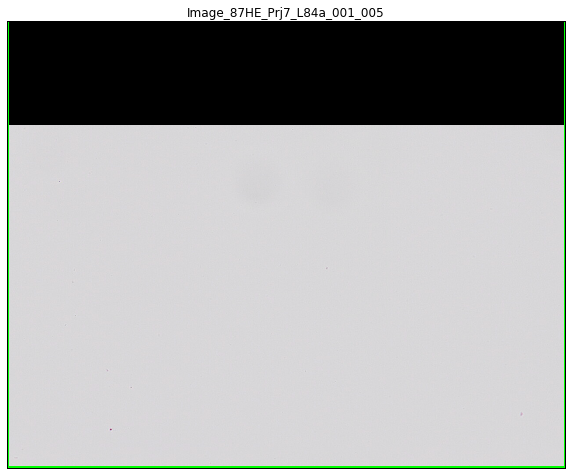

Size of Centroids:  1


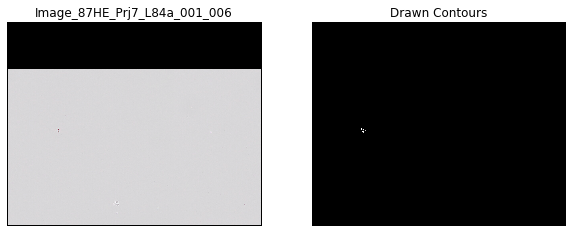

Size of Clusters:  1
Current number of clusters:  1
Number of cells in clusters: 
	 list_0 :  2
Current number of clusters:  0


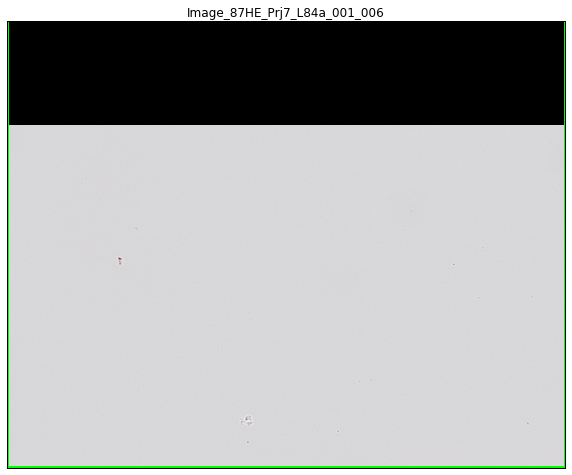

Size of Centroids:  0


In [ ]:
def main():
    fs = open('HE_Results.txt', 'w')
    fs.write('\nFile Name\tCluster No.\tNo. of Cells in Cluster\tCluster Size\n\n')
    file_path = os.listdir("HEImgs/")
    for infile in file_path:
        if (infile[-4:] == ".tif"):
            (img, cluster_results, nuclei_img) = Image_Processing(infile)
            cv2.imwrite('./HE_Pngs/' + infile[:-4] + '.png', img)
            cv2.imwrite('./HE_Mask/'+ infile[:-4]+'_mask.png', nuclei_img)
            if len(cluster_results) == 0:
                fs.write(infile[:-4]+'\t0\t0\t0\n')
            else:
                for a in cluster_results:
                    fs.write(infile[:-4]+'\t'+str(a)+'\t'+str(cluster_results[a][0])+'\t'+str(cluster_results[a][1])+'\n') 
    fs.close()
main()